In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm


# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_simu.rv1'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables.rv1'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.txt', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {'common_common' : '#78ADD2', 'common' : '#78ADD2', 'common_lf' : '#80C680',
             'lf_lf' : '#FFB26E', 'lf' : '#FFB26E'}
MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


In [3]:
# LDSPEC results
DATA_PATH_OLD = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/simulation.100123'
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp/simulation.011425'
DIC_RES_PATH = {}

DIC_RES_PATH['null_h2g50_p20.rep287K'] = {
    'truth' : DATA_PATH + '/null_h2g50_p20.rep287K/rep@',
    'prox_gene_fct_all_ld_ss50K' : DATA_PATH + '/null_h2g50_p20.rep287K.prox_gene_fct_all_ld_ss50K/rep@',
    'prox_gene_fct_all_ld_NB44K' : DATA_PATH + '/null_h2g50_p20.rep287K.prox_gene_fct_all_ld_NB44K/rep@',
}

DIC_RES_PATH['causal_h2g50_p20.rep287K'] = {
    'truth' : DATA_PATH + '/causal_h2g50_p20.rep287K/rep@',
    'prox_gene_fct_all_ld_ss50K' : DATA_PATH + '/causal_h2g50_p20.rep287K.prox_gene_fct_all_ld_ss50K/rep@',
    'prox_gene_fct_all_ld_NB44K' : DATA_PATH + '/causal_h2g50_p20.rep287K.prox_gene_fct_all_ld_NB44K/rep@',
}

### Read results 

In [4]:
dic_res = {}
dic_n_rep = {}

for simu in DIC_RES_PATH:
    dic_n_rep[simu] = 0
    for i_rep in range(100):
        if os.path.exists(DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.sumstats.gz'):
            dic_n_rep[simu] = i_rep + 1
        else:
            break           
        
    dic_res[simu] = {}
    for i_rep in range(dic_n_rep[simu]):
        dic_res[simu][i_rep] = {}
        for md in DIC_RES_PATH[simu]:
            dic_res[simu][i_rep][md] = {}
            if md == 'truth':
                for res in ['tau', 'omega']:
                    dic_res[simu][i_rep]['truth'][res] = pd.read_csv(
                        DIC_RES_PATH[simu]['truth'].replace('@','%d'%i_rep)+'.eff_%s.tsv' % res, 
                        sep='\t', index_col=0
                    )
            else:
                if os.path.exists(DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv') is False:
                    print('Missing: ', DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.tau.tsv')
                    continue
                for res in ['tau', 'omega']:                
                    dic_res[simu][i_rep][md][res] = pd.read_csv(
                        DIC_RES_PATH[simu][md].replace('@','%d'%i_rep)+'.%s.tsv' % res, sep='\t', index_col=0
                )
    
    # Print h2
    for md in DIC_RES_PATH[simu]:
        if md=='truth': 
            continue
        v_ = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        v_se = np.array([dic_res[simu][x][md]['tau'].loc['AN:all', 'h2_se'] for x in range(dic_n_rep[simu])])
        v_true = np.array([dic_res[simu][0]['truth']['tau'].loc['AN:all', 'h2'] for x in range(dic_n_rep[simu])])
        print('%-20s n_rep=%d \t %-20s h2=%0.3f, h2_true=%0.3f, avg_jnse=%0.3f, empi_se=%0.3f' %(
            simu, dic_n_rep[simu], md, np.mean(v_), np.mean(v_true), np.mean(v_se), np.std(v_)
        ))

null_h2g50_p20.rep287K n_rep=50 	 prox_gene_fct_all_ld_ss50K h2=0.504, h2_true=0.496, avg_jnse=0.024, empi_se=0.016
null_h2g50_p20.rep287K n_rep=50 	 prox_gene_fct_all_ld_NB44K h2=0.513, h2_true=0.496, avg_jnse=0.025, empi_se=0.015
causal_h2g50_p20.rep287K n_rep=50 	 prox_gene_fct_all_ld_ss50K h2=0.361, h2_true=0.345, avg_jnse=0.015, empi_se=0.011
causal_h2g50_p20.rep287K n_rep=50 	 prox_gene_fct_all_ld_NB44K h2=0.369, h2_true=0.345, avg_jnse=0.016, empi_se=0.013


In [5]:
# Supp. Table for null and causal simulations and all quantities
term_list = [
    ['tau', 'tau', 0], ['tau', 'h2', 0], ['tau', 'scv', 0], 
    ['tau', 'h2_enrich', 1], 
#     ['tau', 'scv_enrich', 1], 
    ['tau', 'h2_shrink', 1], 
    ['omega', 'omega', 0], ['omega', 'cov', 0], ['omega', 'cor', 0], ['omega', 'ecov', 0], ['omega', 'ecor', 0],
]
col_list = [
    'annot', 'term', 'term_identifier', 'truth', 'jnse', 
    'empi.mean', 'empi.se', 'empi.p', 'empi.fwer', 'empi.sig_str',
    'meta.mean', 'meta.se', 'meta.p', 'meta.fwer', 'meta.sig_str'
]

DIC_SUMMARY = {}
for simu in DIC_RES_PATH:
    DIC_SUMMARY[simu] = {}
    for md in DIC_RES_PATH[simu]: 
        if md == 'truth':
            continue
        DIC_SUMMARY[simu][md] = None
        res_tau_list = [dic_res[simu][x][md]['tau'] for x in range(dic_n_rep[simu])]
        res_omega_list = [dic_res[simu][x][md]['omega'] for x in range(dic_n_rep[simu])]
        for res,term,null_val in term_list:
            temp_df = pd.DataFrame(index=dic_res[simu][0][md][res].index, columns=col_list, dtype=float)
            temp_df['annot'] = temp_df.index
            temp_df['term'] = DIC_NAME[term]
            temp_df['term_identifier'] = term
            for row in temp_df.index:
                # empi.mean & empi.se
                v_ = [dic_res[simu][x][md][res].loc[row, term] for x in range(dic_n_rep[simu])]
                temp_df.loc[row, 'empi.mean'] = np.mean(v_)
                temp_df.loc[row, 'empi.se'] = np.std(v_) / np.sqrt(dic_n_rep[simu])
                # jnse
                v_se_ = [dic_res[simu][x][md][res].loc[row, '%s_se'%term] for x in range(dic_n_rep[simu])]
                temp_df.loc[row, 'jnse'] = np.sqrt(np.mean(np.array(v_se_)**2)) / np.sqrt(dic_n_rep[simu])
                # truth
                if row in dic_res[simu][0]['truth'][res].index: 
                    v_ = [dic_res[simu][x]['truth'][res].loc[row, term] for x in range(dic_n_rep[simu])]
                    temp_df.loc[row, 'truth'] = np.mean(v_)
                if (simu=='null_h2g50_p20') & (term in ['tau', 'omega', 'cov', 'cor', 'ecor']):
                    temp_df.loc[temp_df['truth'].isna(), 'truth'] = null_val
                if (simu=='causal_h2g50_p20') & (term in ['tau', 'omega']):
                    temp_df.loc[temp_df['truth'].isna(), 'truth'] = null_val
                if (simu=='causal_h2g50_p20') & (term in ['ecor']) & row.startswith('pAN:proxy'):
                    temp_df.loc[row, 'truth'] = 0                         
                # meta-analysis                
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                temp_df.loc[row, ['meta.mean', 'meta.se', 'meta.p']] = mean_,se_,p_
            
            # multiple testing: meta
            temp_df['meta.fwer'] = temp_df['meta.p'] * temp_df.shape[0]
            print(temp_df.shape[0])
            temp_df['meta.sig_str'] = ['*' if x<0.05 else '' for x in temp_df['meta.fwer']]  
            # multiple testing: empi
            temp_z = np.array((temp_df['empi.mean']-null_val) / temp_df['empi.se'])
            temp_df['empi.p'] = ldspec.util.zsc2pval(temp_z)
            temp_df['empi.fwer'] = temp_df['empi.p'] * temp_df.shape[0]
            temp_df['empi.sig_str'] = ['*' if x<0.05 else '' for x in temp_df['empi.fwer']]

            if DIC_SUMMARY[simu][md] is None:
                DIC_SUMMARY[simu][md] = temp_df.copy()
            else:
                DIC_SUMMARY[simu][md] = pd.concat([DIC_SUMMARY[simu][md], temp_df], axis=0)
                
        # Write tables
        DIC_SUMMARY[simu][md][[
            'annot', 'term', 'term_identifier', 'truth', 'jnse', 'empi.mean', 'empi.se', 'empi.p', 'empi.fwer',
        ]].to_csv(TAB_PATH+'/fig1.%s.%s.tsv' % (simu, md), sep='\t', index=False)

165
165
165
165
165
136
136
136


/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:365: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:369: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))


136
136
165
165
165
165
165
136
136
136
136
136
165
165
165
165
165
136
136
136
136
136
165
165
165
165
165
136
136
136
136
136


In [11]:
TAB_PATH

'/n/groups/price/martin/LDSPEC_data/results/tables.rv1'

### Figure 2a: null simulation

In [6]:
simu = 'null_h2g50_p20.rep287K'
md = 'prox_gene_fct_all_ld_ss50K'
term = 'cor'
df_plot = DIC_SUMMARY[simu][md].loc[DIC_SUMMARY[simu][md]['term_identifier']==term].copy()

ind_select = df_plot['meta.sig_str']=='*'
print('meta.fwer %d / %d significant ' % (ind_select.sum(), df_plot.shape[0]))
display(df_plot.loc[ind_select])

ind_select = df_plot['empi.sig_str']=='*'
print('empi.fwer %d / %d significant ' % (ind_select.sum(), df_plot.shape[0]))
display(df_plot.loc[ind_select])

ind_select = ['ld_p0_p100' in x for x in df_plot.index]
print('Pos-LD with neg-cor: %d/%d' %((df_plot.loc[ind_select, 'empi.mean']<0).sum(), np.sum(ind_select)))
ind_select = ['ld_n100_p0' in x for x in df_plot.index]
print('Neg-LD with pos-cor: %d/%d' %((df_plot.loc[ind_select, 'empi.mean']>0).sum(), np.sum(ind_select)))

meta.fwer 3 / 136 significant 


,annot,term,term_identifier,truth,jnse,empi.mean,empi.se,empi.p,empi.fwer,empi.sig_str,meta.mean,meta.se,meta.p,meta.fwer,meta.sig_str
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p10...,SNP-pair effect correlation,cor,NaN,0.036885,-0.057645,0.035602,0.105417,14.336736,,-0.116331,0.027850,0.000015,0.002089,*
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_n100_p0_maf_common_block,pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_n100_p...,SNP-pair effect correlation,cor,NaN,0.038390,-0.079955,0.038337,0.037015,5.034084,,-0.079325,0.027431,0.000331,0.045070,*
pAN:Transcribed_Hoffman_proxy_0_1000_ld_n100_p0_maf_common_block,pAN:Transcribed_Hoffman_proxy_0_1000_ld_n100_p...,SNP-pair effect correlation,cor,NaN,0.046108,-0.089466,0.039479,0.023441,3.188027,,-0.117449,0.039234,0.000113,0.015332,*


empi.fwer 0 / 136 significant 


,annot,term,term_identifier,truth,jnse,empi.mean,empi.se,empi.p,empi.fwer,empi.sig_str,meta.mean,meta.se,meta.p,meta.fwer,meta.sig_str


Pos-LD with neg-cor: 23/68
Neg-LD with pos-cor: 38/68


n_pannot=34


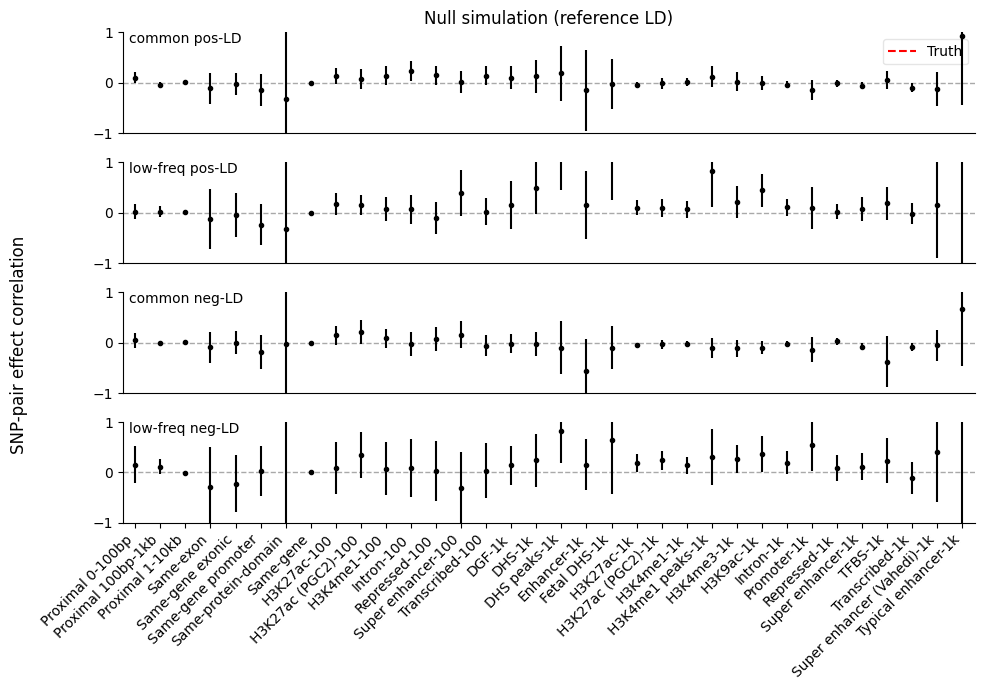

In [7]:
# Figure
dic_name = {
    ('p0_p100', 'common') : 'common pos-LD',
    ('p0_p100', 'lf') : 'low-freq pos-LD',
    ('n100_p0', 'common') : 'common neg-LD',
    ('n100_p0', 'lf') : 'low-freq neg-LD',
}
    
plot_list = [x for x in DF_PANNOT.index if 'pAN:%s_ld_n100_p0_maf_lf_block'%x in df_plot.index]
print('n_pannot=%d' % len(plot_list))

fig = plt.figure(figsize=[10, 7])
for i_plot,(lbin,mbin) in enumerate([
    ('p0_p100', 'common'), ('p0_p100', 'lf'), ('n100_p0', 'common'), ('n100_p0', 'lf'),
]):
    row_list = ['pAN:%s_ld_%s_maf_%s_block'%(x,lbin,mbin) for x in plot_list]
    
    ax = plt.subplot(4,1,i_plot+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.errorbar(np.arange(len(plot_list)), df_plot.loc[row_list, 'empi.mean'],
                 yerr=df_plot.loc[row_list, 'empi.se']*1.96, fmt= '.', color='k', zorder=10)

    for i_row,row in enumerate(row_list):
        if i_row == 0: # Add label
            plt.plot([i_row-0.3, i_row+0.3], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', label='Truth', zorder=5)
        else:
            plt.plot([i_row-0.3, i_row+0.3], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', zorder=5)
        plt.text(i_row, max(0, df_plot.loc[row, 'empi.mean'] + df_plot.loc[row, 'empi.se'] * 1.96), 
                 df_plot.loc[row, 'empi.sig_str'], ha='center', va='bottom')

    plt.plot([-0.5, len(plot_list)-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
    plt.xlim([-0.5, len(plot_list)-0.5])
    plt.ylim([-1, 1])
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    plt.text(-0.25, 1, dic_name[(lbin,mbin)], ha='left', va='top')
    if i_plot == 0:
        plt.title('Null simulation (reference LD)')
        plt.xticks([], [])
        plt.legend(loc='upper right', framealpha=0.5)
    if i_plot == 1:
        plt.xticks([], [])
    if i_plot == 2:
        plt.xticks([], [])
    if i_plot == 3:
        plt.xticks(np.arange(len(plot_list)), [DIC_NAME[x] if x in DIC_NAME else x for x in plot_list], 
               rotation=45, ha='right')

fig.supylabel('SNP-pair effect correlation')
plt.tight_layout()
plt.savefig(FIG_PATH + '/cor.%s.%s.pdf'%(simu,md))
plt.show()   

### Figure 2b: causal simulation

In [8]:
simu = 'causal_h2g50_p20.rep287K'
md = 'prox_gene_fct_all_ld_ss50K'
term = 'cor'
df_plot = DIC_SUMMARY[simu][md].loc[DIC_SUMMARY[simu][md]['term_identifier']==term].copy()
print('n_pannot=%s' % df_plot.shape[0])

for x in df_plot.index[~df_plot['truth'].isna()]:
    df_plot.loc[x.replace('p0_p100', 'n100_p0'), 'truth'] = 0
ind_select = ~df_plot['truth'].isna()
print('Causal pannots %d' % ind_select.sum())
display(df_plot.loc[ind_select])

n_pannot=136
Causal pannots 12


,annot,term,term_identifier,truth,jnse,empi.mean,empi.se,empi.p,empi.fwer,empi.sig_str,meta.mean,meta.se,meta.p,meta.fwer,meta.sig_str
pAN:proxy_0_100_ld_p0_p100_maf_common_block,pAN:proxy_0_100_ld_p0_p100_maf_common_block,SNP-pair effect correlation,cor,-0.413463,0.033637,-0.169473,0.038800,1.254453e-05,1.706056e-03,*,-0.180554,0.037701,3.702371e-06,5.035225e-04,*
pAN:proxy_0_100_ld_p0_p100_maf_lf_block,pAN:proxy_0_100_ld_p0_p100_maf_lf_block,SNP-pair effect correlation,cor,-0.433504,0.046567,-0.101796,0.050094,4.214500e-02,5.731720e+00,,-0.128327,0.054162,2.294588e-02,3.120639e+00,
pAN:proxy_100_1000_ld_p0_p100_maf_common_block,pAN:proxy_100_1000_ld_p0_p100_maf_common_block,SNP-pair effect correlation,cor,-0.269695,0.016208,-0.079992,0.016092,6.662368e-07,9.060821e-05,*,-0.075785,0.015566,2.619551e-07,3.562589e-05,*
pAN:proxy_100_1000_ld_p0_p100_maf_lf_block,pAN:proxy_100_1000_ld_p0_p100_maf_lf_block,SNP-pair effect correlation,cor,-0.264750,0.037991,-0.008217,0.033591,8.067530e-01,1.097184e+02,,-0.044072,0.029953,3.530485e-02,4.801459e+00,
pAN:proxy_0_100_ld_n100_p0_maf_common_block,pAN:proxy_0_100_ld_n100_p0_maf_common_block,SNP-pair effect correlation,cor,0.000000,0.047131,0.001341,0.056688,9.811255e-01,1.334331e+02,,0.020752,0.054457,6.482625e-01,8.816370e+01,
pAN:proxy_0_100_ld_n100_p0_maf_lf_block,pAN:proxy_0_100_ld_n100_p0_maf_lf_block,SNP-pair effect correlation,cor,0.000000,0.114589,0.216825,0.131085,9.811196e-02,1.334323e+01,,0.233266,0.148652,9.532567e-02,1.296429e+01,
pAN:proxy_100_1000_ld_n100_p0_maf_common_block,pAN:proxy_100_1000_ld_n100_p0_maf_common_block,SNP-pair effect correlation,cor,0.000000,0.017927,0.008898,0.015774,5.726728e-01,7.788350e+01,,0.011793,0.013963,3.931446e-01,5.346767e+01,
pAN:proxy_100_1000_ld_n100_p0_maf_lf_block,pAN:proxy_100_1000_ld_n100_p0_maf_lf_block,SNP-pair effect correlation,cor,0.000000,0.048859,0.013805,0.042490,7.452519e-01,1.013543e+02,,0.007979,0.040665,6.157963e-01,8.374830e+01,
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_common_block,pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p10...,SNP-pair effect correlation,cor,-0.331204,0.020033,-0.128533,0.018014,9.651330e-13,1.312581e-10,*,-0.137749,0.017910,1.144752e-12,1.556862e-10,*
pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p100_maf_lf_block,pAN:SuperEnhancer_Hnisz_proxy_0_1000_ld_p0_p10...,SNP-pair effect correlation,cor,-0.419237,0.056709,-0.218336,0.070709,2.016456e-03,2.742380e-01,,-0.311457,0.047349,3.122911e-07,4.247159e-05,*


n_pannot=3


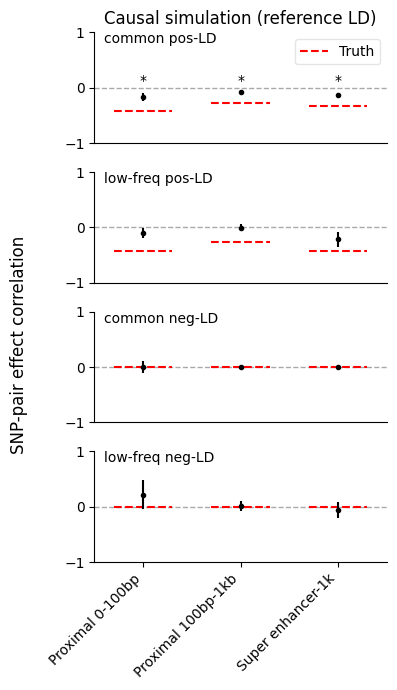

In [9]:
# Figure
dic_name = {
    ('p0_p100', 'common') : 'common pos-LD',
    ('p0_p100', 'lf') : 'low-freq pos-LD',
    ('n100_p0', 'common') : 'common neg-LD',
    ('n100_p0', 'lf') : 'low-freq neg-LD',
}
    
pannot_list_causal = ['proxy_0_100', 'proxy_100_1000', 'SuperEnhancer_Hnisz_proxy_0_1000']
plot_list = [x for x in pannot_list_causal if 'pAN:%s_ld_n100_p0_maf_lf_block'%x in df_plot.index]
print('n_pannot=%d' % len(plot_list))

fig = plt.figure(figsize=[4, 7])
for i_plot,(lbin,mbin) in enumerate([
    ('p0_p100', 'common'), ('p0_p100', 'lf'), ('n100_p0', 'common'), ('n100_p0', 'lf'),
]):
    row_list = ['pAN:%s_ld_%s_maf_%s_block'%(x,lbin,mbin) for x in plot_list]  
    
    ax = plt.subplot(4,1,i_plot+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.errorbar(np.arange(len(plot_list)), df_plot.loc[row_list, 'empi.mean'],
                 yerr=df_plot.loc[row_list, 'empi.se']*1.96, fmt= '.', color='k', zorder=10)

    for i_row,row in enumerate(row_list):
        if i_row == 0: # Add label
            plt.plot([i_row-0.3, i_row+0.3], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', label='Truth', zorder=5)
        else:
            plt.plot([i_row-0.3, i_row+0.3], [df_plot.loc[row, 'truth'], df_plot.loc[row, 'truth']],
                     '--', color='r', zorder=5)
        plt.text(i_row, max(0, df_plot.loc[row, 'empi.mean'] + df_plot.loc[row, 'empi.se'] * 1.96), 
                 df_plot.loc[row, 'empi.sig_str'], ha='center', va='bottom')

    plt.plot([-0.5, len(plot_list)-0.5], [0, 0], "--", linewidth=1, zorder=0, color="darkgrey")
    plt.xlim([-0.5, len(plot_list)-0.5])
    plt.ylim([-1, 1])
    plt.text(-0.4, 1, dic_name[(lbin,mbin)], ha='left', va='top')
    if i_plot == 0:
        plt.title('Causal simulation (reference LD)')
        plt.xticks([], [])
        plt.legend(loc='upper right', framealpha=0.5)
    if i_plot == 1:
        plt.xticks([], [])
    if i_plot == 2:
        plt.xticks([], [])
    if i_plot == 3:
        plt.xticks(np.arange(len(plot_list)), [DIC_NAME[x] if x in DIC_NAME else x for x in plot_list], 
               rotation=45, ha='right')

fig.supylabel('SNP-pair effect correlation')
plt.tight_layout()
plt.savefig(FIG_PATH + '/cor.%s.%s.pdf'%(simu,md))
plt.show()   

In [10]:
FIG_PATH

'/n/groups/price/martin/LDSPEC_data/results/fig_simu.rv1'